<a href="https://colab.research.google.com/github/0raghad/churn/blob/main/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# churn

Use the "Run" button to execute the code.

In [6]:
pip install opendatasets --upgrade --quietfb105e86edf5b82071713b9a38d0ad2b

In [7]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/blastchar/telco-customer-churn'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alharbiraghad
Your Kaggle Key: ··········


100%|██████████| 172k/172k [00:00<00:00, 31.2MB/s]

In [8]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# oversampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN

# train test split
from sklearn.model_selection import train_test_split

# model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve


# model evaluation & tuning hyperparameter
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
import math

# encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import itertools

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [9]:
df = pd.read_csv("/content/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [10]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Exploratory Data Analysis and Data Cleaning

In [11]:
df.drop(columns='customerID', inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


we can see that the `TotalCharges` have the wrong data type so we will change it to numeric data type.


In [13]:
# Object values
for x in df.columns:
   if df[x].dtype == 'object':
      print(x, ': ',df[x]. nunique(),' unique values : ',df[x].unique())

gender :  2  unique values :  ['Female' 'Male']
Partner :  2  unique values :  ['Yes' 'No']
Dependents :  2  unique values :  ['No' 'Yes']
PhoneService :  2  unique values :  ['No' 'Yes']
MultipleLines :  3  unique values :  ['No phone service' 'No' 'Yes']
InternetService :  3  unique values :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity :  3  unique values :  ['No' 'Yes' 'No internet service']
OnlineBackup :  3  unique values :  ['Yes' 'No' 'No internet service']
DeviceProtection :  3  unique values :  ['No' 'Yes' 'No internet service']
TechSupport :  3  unique values :  ['No' 'Yes' 'No internet service']
StreamingTV :  3  unique values :  ['No' 'Yes' 'No internet service']
StreamingMovies :  3  unique values :  ['No' 'Yes' 'No internet service']
Contract :  3  unique values :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling :  2  unique values :  ['Yes' 'No']
PaymentMethod :  4  unique values :  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (aut

In [14]:
df['TotalCharges']= pd.to_numeric(df['TotalCharges'], errors='coerce')

In [15]:
df[df['TotalCharges'].isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [16]:
df.dropna(inplace=True)

In [17]:
# replace redundant values
df.replace({'No phone service':'No',
              'No internet service':'No'},
               inplace=True)

df['SeniorCitizen'].replace({0:'No',
                                1:'Yes'},
                                inplace=True)

###   Visualization

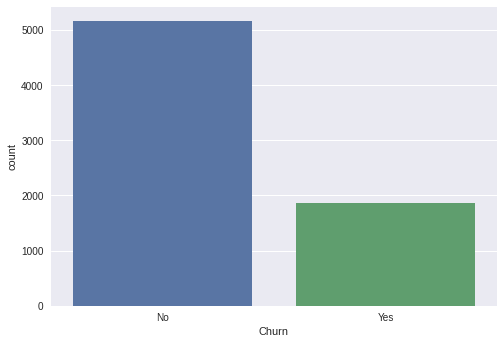

In [18]:
sns.countplot(x='Churn', data=df)

In [19]:
def percentage_stacked_plot(columns_to_plot):
    
    '''
    Prints a 100% stacked plot of the response variable for independent variable of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
            Returns:
                    None
    '''
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
 
    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):
  
        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(df[column], df['Churn']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0)

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.62, 0.62, 0.62),
                  title='Churn', fancybox=True)


        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

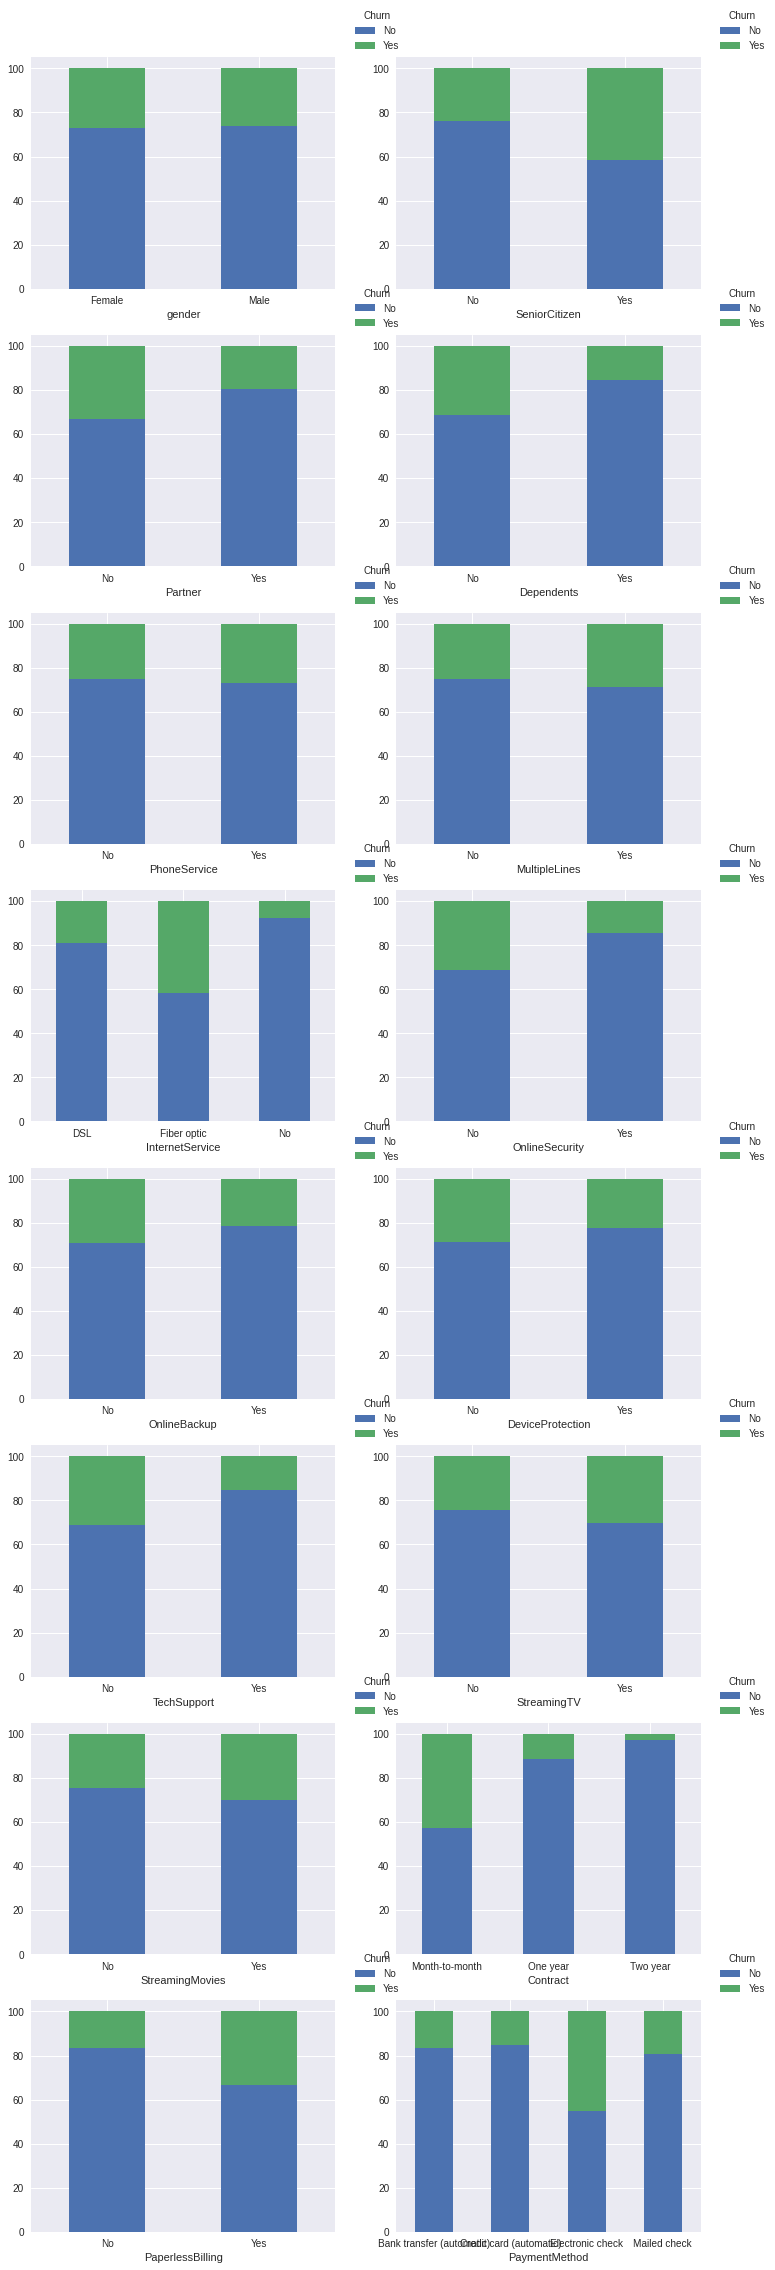

In [20]:
# demographic column names
column_object = [x for x in df.columns if df[x].dtype == 'object']
column_object.remove('Churn')
column_numerical = [x for x in df.columns if df[x].dtype != 'object']
# stacked plot of demographic columns
percentage_stacked_plot(column_object)

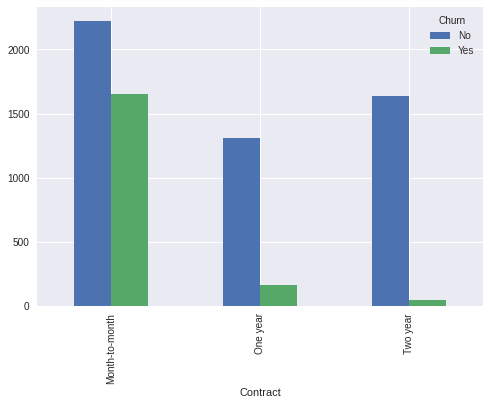

In [21]:
freq=pd.crosstab(df.Contract, df.Churn)
freq.plot(kind='bar')

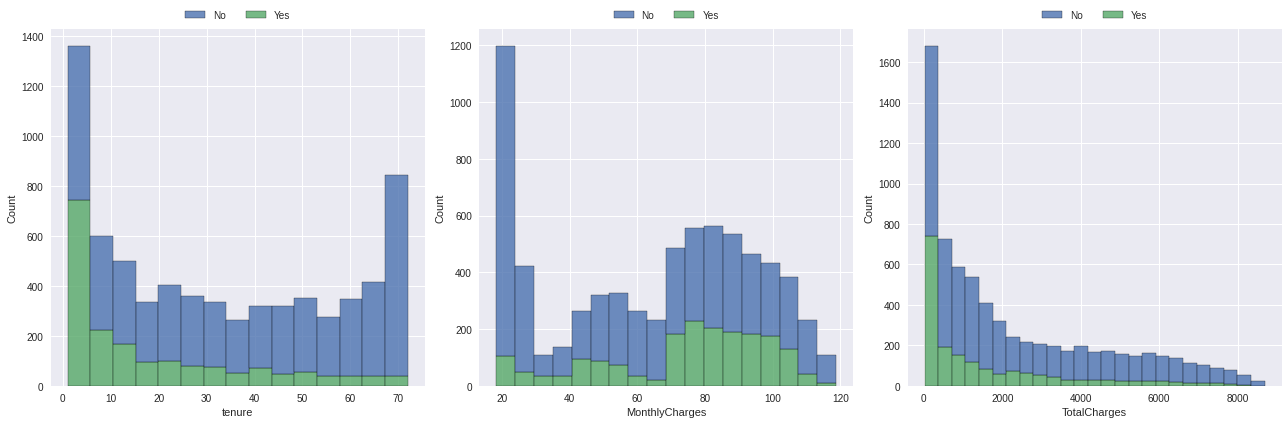

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

for i, col in enumerate(column_numerical):
  sns.histplot(data=df, x=col, hue='Churn', multiple='stack', ax=ax[i], alpha=0.8)
  sns.move_legend(ax[i], "lower center", bbox_to_anchor=(0.5, 1), ncol=3, title='', frameon=False)

plt.tight_layout()
sns.despine()
plt.show()

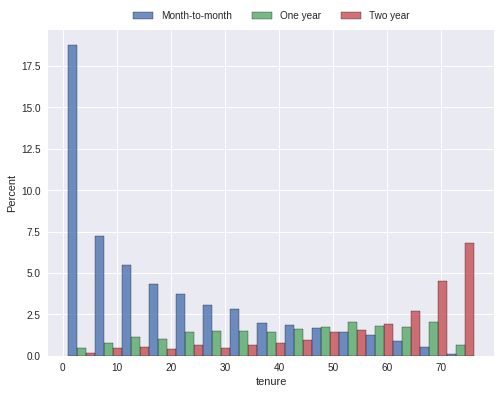

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(data=df, x='tenure', hue='Contract', stat='percent', multiple='dodge', ax=ax, binwidth=5, alpha=0.8)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=3, title='', frameon=False)

sns.despine()  
plt.show()

###  Data Preprocessing

In [24]:
label_encoding_columns = ['gender', 'Partner', 'Dependents', 'PaperlessBilling', 'PhoneService', 'Churn']

# encode categorical binary features using label encoding
for column in label_encoding_columns:
    if column == 'gender':
        df[column] = df[column].map({'Female': 1, 'Male': 0})
    else: 
        df[column] = df[column].map({'Yes': 1, 'No': 0}) 

In [25]:
df = pd.get_dummies(df, columns = [x for x in df.columns if df[x].dtype == 'object'] )

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   7032 non-null   int64  
 1   Partner                                  7032 non-null   int64  
 2   Dependents                               7032 non-null   int64  
 3   tenure                                   7032 non-null   int64  
 4   PhoneService                             7032 non-null   int64  
 5   PaperlessBilling                         7032 non-null   int64  
 6   MonthlyCharges                           7032 non-null   float64
 7   TotalCharges                             7032 non-null   float64
 8   Churn                                    7032 non-null   int64  
 9   SeniorCitizen_No                         7032 non-null   uint8  
 10  SeniorCitizen_Yes                        7032 no

In [27]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X = StandardScaler().fit_transform(X)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1234, stratify=y)

In [29]:
print('X shape\t:', X.shape)
print('y shape\t:', y.shape)
print()
print('X_train shape\t:', X_train.shape)
print('y_train shape\t:', y_train.shape)
print()
print('X_test shape\t:', X_test.shape)
print('y_test shape\t:', y_test.shape)

X shape	: (7032, 34)
y shape	: (7032,)

X_train shape	: (5625, 34)
y_train shape	: (5625,)

X_test shape	: (1407, 34)
y_test shape	: (1407,)


In [30]:
# Standardizing the Dataset
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [31]:
def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    print("TRAINIG RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

    print("TESTING RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

In [32]:
model_lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=50)
model_lr.fit(X_train, y_train)
evaluate(model_lr, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[3029 1101]
 [ 277 1218]]
ACCURACY SCORE:
0.7550
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.916213     0.525226  0.755022     0.720720      0.812297
recall        0.733414     0.814716  0.755022     0.774065      0.755022
f1-score      0.814685     0.638700  0.755022     0.726692      0.767912
support    4130.000000  1495.000000  0.755022  5625.000000   5625.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[758 275]
 [ 92 282]]
ACCURACY SCORE:
0.7392
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.891765    0.506284  0.739161     0.699024      0.789299
recall        0.733785    0.754011  0.739161     0.743898      0.739161
f1-score      0.805098    0.605800  0.739161     0.705449      0.752122
support    1033.000000  374.000000  0.739161  1407.000000   1407.000000


In [33]:
model_rf = RandomForestClassifier(random_state=50)
model_rf.fit(X_train, y_train)
evaluate(model_rf, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[4127    3]
 [   8 1487]]
ACCURACY SCORE:
0.9980
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.998065     0.997987  0.998044     0.998026      0.998044
recall        0.999274     0.994649  0.998044     0.996961      0.998044
f1-score      0.998669     0.996315  0.998044     0.997492      0.998043
support    4130.000000  1495.000000  0.998044  5625.000000   5625.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[933 100]
 [224 150]]
ACCURACY SCORE:
0.7697
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.806396    0.600000  0.769723     0.703198      0.751533
recall        0.903195    0.401070  0.769723     0.652132      0.769723
f1-score      0.852055    0.480769  0.769723     0.666412      0.753362
support    1033.000000  374.000000  0.769723  1407.000000   1407.000000


In [34]:
xgb_clf = XGBClassifier(random_state=50)
xgb_clf.fit(X_train, y_train)
evaluate(xgb_clf, X_train, X_test, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[3781  349]
 [ 620  875]]
ACCURACY SCORE:
0.8277
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.859123     0.714869  0.827733     0.786996      0.820784
recall        0.915496     0.585284  0.827733     0.750390      0.827733
f1-score      0.886414     0.643619  0.827733     0.765017      0.821885
support    4130.000000  1495.000000  0.827733  5625.000000   5625.000000
TESTING RESULTS: 
CONFUSION MATRIX:
[[944  89]
 [194 180]]
ACCURACY SCORE:
0.7989
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.829525    0.669145  0.798863     0.749335      0.786894
recall        0.913843    0.481283  0.798863     0.697563      0.798863
f1-score      0.869645    0.559876  0.798863     0.714760      0.787304
support    1033.000000  374.000000  0.798863  1407.000000   1407.000000


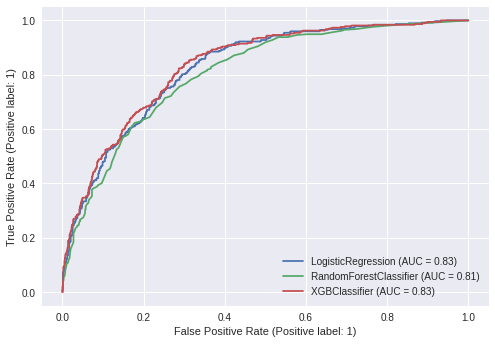

In [35]:
classifiers = [model_lr, model_rf , xgb_clf]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

In [36]:
threshold = 0.95

# Calculate correlations
corr_matrix = df.corr().abs()

# Subset to the upper triangle of correlation matrix
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Identify names of columns with correlation above threshold
to_drop = [column for column in upper.columns if any(
    upper[column] >= threshold)]

print(
    f'There are {len(to_drop)} columns to drop with correlation > {threshold}')

There are 8 columns to drop with correlation > 0.95


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [37]:
df.drop(columns=to_drop, inplace=True)
df.shape

(7032, 27)

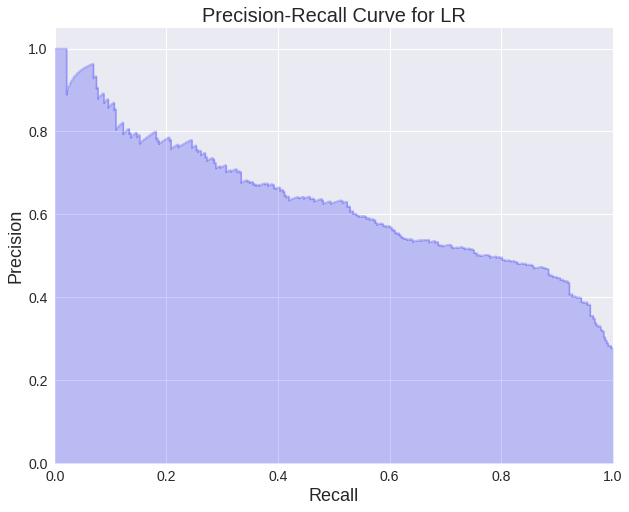

In [38]:
def plot_precision_recall(test_y, probs, title='Precision Recall Curve', threshold_selected=None):
    """Plot a precision recall curve for predictions. 
       Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py"""

    precision, recall, threshold = precision_recall_curve(test_y, probs)
    plt.figure(figsize=(10, 8))
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall', size=18)
    plt.ylabel('Precision', size=18)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title, size=20)
    plt.xticks(size=14)
    plt.yticks(size=14)

    if threshold_selected:
        p = precision(np.where(threshold == threshold_selected)[0])
        r = recall(np.where(threshold == threshold_selected)[0])
        plt.scatter(r, p, marker='*', size=200)
        plt.vlines(r, ymin=0, ymax=p, linestyles='--')
        plt.hlines(p, xmin=0, xmax=r, linestyles='--')

    pr = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1],
                       'threshold': threshold})
    return pr


probs = model_lr.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='Precision-Recall Curve for LR')

In [39]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

,precision,recall,threshold
0,0.276832,1.000000,0.010783
16,0.279401,0.997326,0.012289
30,0.282362,0.997326,0.014409
29,0.282148,0.997326,0.014229
28,0.281935,0.997326,0.013962


In [40]:
recall_attained = 0.75
recall_above = pr_data.loc[pr_data['recall'] >= recall_attained].copy()
recall_above.sort_values('precision', ascending=False, inplace=True)
recall_above.head()

,precision,recall,threshold
804,0.514652,0.751337,0.507852
803,0.513711,0.751337,0.507718
802,0.512774,0.751337,0.507566
801,0.511840,0.751337,0.505542
800,0.510909,0.751337,0.504468


In [41]:
precision_attained = recall_above.iloc[0, 0]
threshold_required = recall_above.iloc[0, -1]

print(
    f'At a threshold of {round(threshold_required, 4)} the recall is {100 * recall_attained:.2f}% and the precision is {round(100 * precision_attained, 4)}%')

At a threshold of 0.5079 the recall is 75.00% and the precision is 51.4652%


In [42]:
def plot_precision_recall(test_y, probs, title='Precision Recall Curve', threshold_selected=None):
    """Plot a precision recall curve for predictions. 
       Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py"""

    precision, recall, threshold = precision_recall_curve(test_y, probs)
    plt.figure(figsize=(10, 10))
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall', size=24)
    plt.ylabel('Precision', size=24)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title, size=24)
    plt.xticks(size=18)
    plt.yticks(size=18)

    if threshold_selected:
        p = precision[np.where(threshold == threshold_selected)[0]]
        r = recall[np.where(threshold == threshold_selected)[0]]
        plt.scatter(r, p, marker='*', s=600, c='r')
        plt.vlines(r, ymin=0, ymax=p, linestyles='--')
        plt.hlines(p, xmin=0, xmax=r, linestyles='--')
        plt.text(r - 0.1, p + 0.15,
                 s=f'Threshold: {round(threshold_selected, 2)}', size=20, fontdict={'weight': 1000})
        plt.text(r - 0.2, p + 0.075,
                 s=f'Precision: {round(100 * p[0], 2)}% Recall: {round(100 * r[0], 2)}%', size=20,
                 fontdict={'weight': 1000})

    pr = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1],
                       'threshold': threshold})
    return pr

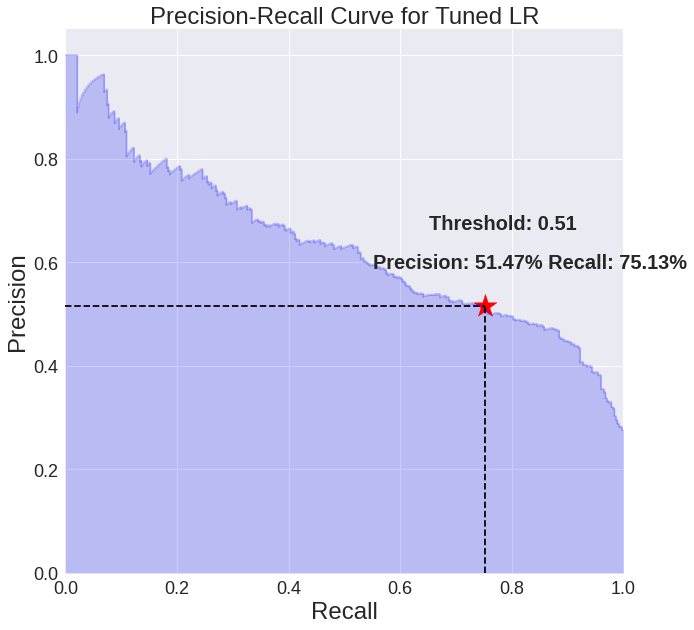

In [43]:
pr_data = plot_precision_recall(y_test, probs, title='Precision-Recall Curve for Tuned LR',
                                threshold_selected=threshold_required)

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.style.use('bmh')
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=22)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=20)
    plt.yticks(tick_marks, classes, size=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 size=20)
    plt.grid(None)
    plt.ylabel('True label', size=22)
    plt.xlabel('Predicted label', size=22)
    plt.tight_layout()

Confusion matrix, without normalization
[[768 265]
 [ 93 281]]


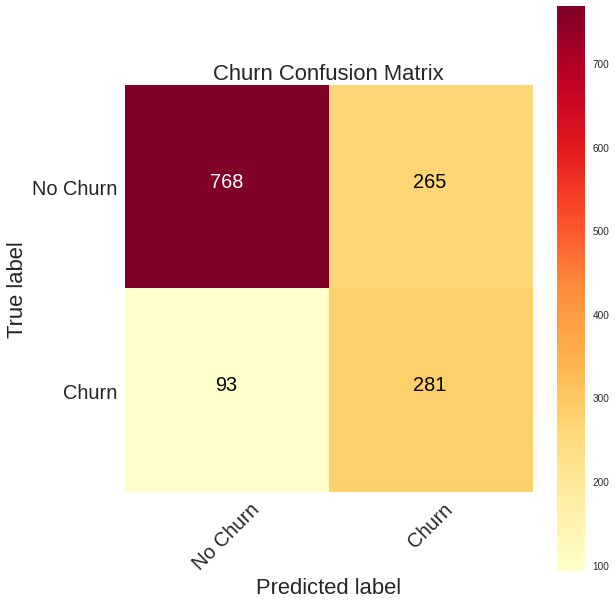

In [45]:
# Make predictions where probability is above threshold
preds = np.zeros(len(y_test))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [46]:
new_probs = model_lr.predict_proba(X_test)[:, 1]


prediction_df = pd.DataFrame({'probability': new_probs})
prediction_df['prediction'] = prediction_df['probability'] > threshold_required
prediction_df.sample(10)

,probability,prediction
183,0.095360,False
1102,0.858232,True
1018,0.091449,False
394,0.876749,True
1198,0.847117,True
1030,0.126619,False
675,0.139661,False
293,0.434789,False
385,0.855026,True
855,0.509323,True


Text(0.5, 1.0, 'Distribution of Predicted Probabilities')

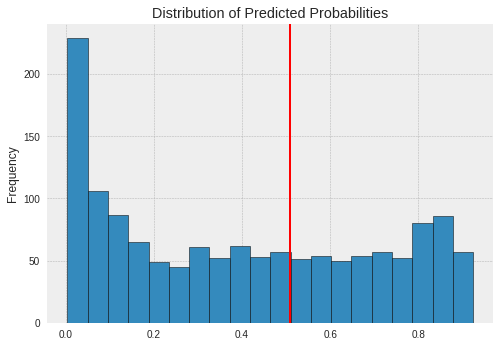

In [47]:
prediction_df['probability'].plot.hist(bins=20, edgecolor='k')
plt.axvline(x=threshold_required, color='r', linewidth=2)
plt.title('Distribution of Predicted Probabilities')